In [1]:
import pandas as pd
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import nltk
import numpy as np
import string
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
FIGURES_PATH = '../figures/'

# Import data

In [3]:
df1 = pd.read_csv('../data/allerhande_1954_1973.csv')
df2 = pd.read_csv('../data/allerhande_1979_2001.csv')
lexicon = pd.read_csv('../data/lexicon.csv')
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1['text_clean'] = df1['text_clean'].str.replace('koolzuurhoudend water', 'koolzuurhoudend_water', case=False)

#remove punctuation
df1['text_clean'] = df1['text_clean'].str.replace('[{}]'.format(string.punctuation), '')
#df1['text_clean'] = df1['text_clean'].str.replace('...', '')
df2['content'] = df2['content'].str.replace('[{}]'.format(string.punctuation), '')
df2.columns = ['avg_quality', 'text_clean', 'issue', 'page_nr', 'total_pages', 'year',
              'month', 'day', 'comment']
allerhande = df1.append(df2)

#load nrc advertisements pickle
ads = pd.read_pickle('../../advis/data/ads/nrc-1945-1994.pkl')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Prepare Lexicons

In [4]:
science_terms = list(lexicon[lexicon['categorie 1'] == 'wetenschap']['woorden'].values)
pleasure_terms = list(lexicon[lexicon['categorie 1'] == 'genot']['woorden'].values)
search_terms = list(lexicon[lexicon['categorie 1'] == 'water']['woorden'].values)

search_terms.remove('koolzuurhoudend')
search_terms.remove('koolzuur')
search_terms.remove('mineraal')
search_terms.append('koolzuurhoudend_water')

In [5]:
# Find fuzzy matches
# need to properly implement this 
# text = df_merge['text_clean'].to_string()
# fuzzy_matches = find_fuzzy_search_terms(text, search_terms, 90)

# Functions

In [6]:
def find_fuzzy_search_terms(text, search_terms, ratio):
    fuzzy_terms = []
    tokens = text.lower().split()
    for search_term in search_terms:
        matches = process.extract(search_term, tokens, scorer=fuzz.ratio, limit=10)
        fuzzies = [match[0] for match in matches if match[1] > ratio]
        if fuzzies:
            fuzzy_terms.append(fuzzies)
    return fuzzy_terms

def extract_chunks(text, search_terms, context_size):
    chunks = []
    tokens = text.lower().split()
    indices = [i for i,word in enumerate(tokens) if word in search_terms]
    #remove overlapping chunks
    for i, ind in enumerate(indices):
        if i > 0:
            if indices[i] < (indices[i-1] + context_size):
                indices.remove(ind)     
        else:
            pass
    
    for ind in indices:
        if ind - context_size < 0:
            left_context = 0
        else:
            left_context = ind - context_size
        if (ind + 1) + context_size > len(tokens):
            right_context = len(tokens)
        else:
            right_context = (ind + 1) + context_size
        chunks.append(tokens[left_context:ind]+ tokens[ind:ind+1] + tokens[ind+1:right_context])
    if chunks:
        return chunks
    else:
        pass

    
def count_terms(text, terms):
    counter = 0
    for term in terms:
        if term in text:
            counter +=1
    return counter

# analysis

## NRC Advertisements

In [7]:
# extract ads with search terms relating to water
water_ads = ads[ads['ocr'].str.contains('{}'.format('|'.join(search_terms)))].copy()

# calculate length of ads
water_ads['length'] = water_ads['ocr'].str.split().apply(lambda x: len(x))

In [8]:
water_ads['year'] = water_ads.reset_index()['date'].dt.year.values
water_ads['month'] = water_ads.reset_index()['date'].dt.month.values

In [9]:
water_ads.sort_values('year', inplace=True)

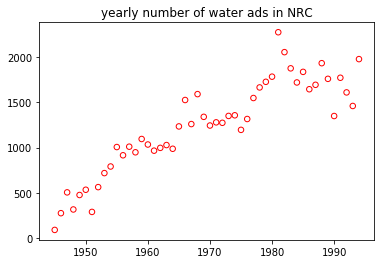

In [10]:
x = water_ads.groupby('year')['ocr'].count().index
y = water_ads.groupby('year')['ocr'].count().values

plt.scatter(x, y, s=30, facecolors='none', edgecolors='r')
plt.title('yearly number of water ads in NRC')
plt.savefig(FIGURES_PATH + 'nrc_yearly_overview.png')

In [11]:
#count science and pleasure terms

water_ads['science'] = water_ads['ocr'].astype(str).apply(lambda x: count_terms(x, science_terms))
water_ads['pleasure'] = water_ads['ocr'].astype(str).apply(lambda x: count_terms(x, pleasure_terms))
        

In [12]:
articles_per_year = water_ads.groupby('year')['ocr'].count().values
words_per_year = water_ads.groupby('year')['length'].mean().values

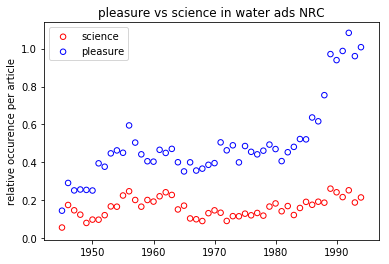

In [13]:
x = water_ads.groupby('year')['ocr'].count().index
y_science = (water_ads.groupby('year')['science'].sum().values / articles_per_year)
y_pleasure = (water_ads.groupby('year')['pleasure'].sum().values / articles_per_year)

plt.scatter(x, y_science, s=30, facecolors='none', edgecolors='r', label='science')
plt.scatter(x, y_pleasure, s=30, facecolors='none', edgecolors='b', label='pleasure')
plt.savefig(FIGURES_PATH + 'nrc_pleasure-science_articles_per_year.png')
plt.title('pleasure vs science in water ads NRC')
plt.ylabel('relative occurence per article')
plt.legend()

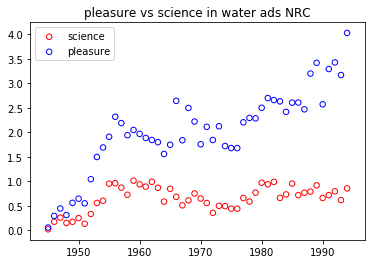

In [14]:
articles_per_year = water_ads.groupby('year')['ocr'].count().values
mean_words_per_year = water_ads.groupby('year')['length'].mean().values

x = water_ads.groupby('year')['ocr'].count().index
y_science = (water_ads.groupby('year')['science'].sum().values / mean_words_per_year)
y_pleasure = (water_ads.groupby('year')['pleasure'].sum().values / mean_words_per_year)

plt.scatter(x, y_science, s=30, facecolors='none', edgecolors='r', label='science')
plt.scatter(x, y_pleasure, s=30, facecolors='none', edgecolors='b', label='pleasure')
plt.title('pleasure vs science in water ads NRC')
plt.savefig(FIGURES_PATH + 'nrc_pleasure-science_mean_words_per_year.png')

plt.legend()

## Allerhande 

### ALLERHANDE ARTICLES

In [18]:
allerhande['length'] = allerhande['text_clean'].astype(str).str.split().apply(lambda x: len(x))

In [19]:
allerhande['science'] = allerhande['text_clean'].astype(str).apply(lambda x: count_terms(x, 
                                                                                science_terms))
allerhande['pleasure'] = allerhande['text_clean'].astype(str).apply(lambda x: count_terms(x,
                                                                                          pleasure_terms))
                                                                                      

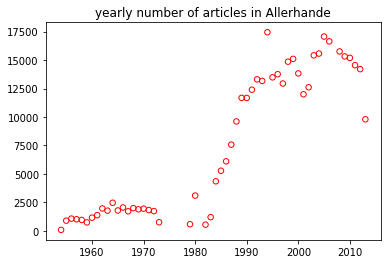

In [20]:
x = allerhande.groupby('year')['text_clean'].count().index
y = allerhande.groupby('year')['text_clean'].count().values

plt.scatter(x, y, s=30, facecolors='none', edgecolors='r')
plt.title('yearly number of articles in Allerhande')
plt.savefig(FIGURES_PATH + 'allerhande_yearly_overview.png')

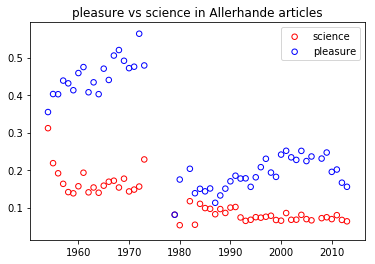

In [21]:
articles_per_year = allerhande.groupby('year')['text_clean'].count().values
words_per_year = allerhande.groupby('year')['length'].mean().values

x = allerhande.groupby('year')['text_clean'].count().index
y_science = (allerhande.groupby('year')['science'].sum().values / articles_per_year)
y_pleasure = (allerhande.groupby('year')['pleasure'].sum().values / articles_per_year)

plt.scatter(x, y_science, s=30, facecolors='none', edgecolors='r', label='science')
plt.scatter(x, y_pleasure, s=30, facecolors='none', edgecolors='b', label='pleasure')
plt.savefig(FIGURES_PATH + 'AH_pleasure-science_articles_per_year.png')
plt.title('pleasure vs science in Allerhande articles')
plt.legend()

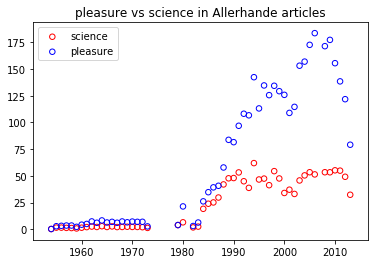

In [22]:
articles_per_year = allerhande.groupby('year')['text_clean'].count().values
words_per_year = allerhande.groupby('year')['length'].mean().values

x = allerhande.groupby('year')['text_clean'].count().index
y_science = (allerhande.groupby('year')['science'].sum().values / words_per_year)
y_pleasure = (allerhande.groupby('year')['pleasure'].sum().values / words_per_year)

plt.scatter(x, y_science, s=30, facecolors='none', edgecolors='r', label='science')
plt.scatter(x, y_pleasure, s=30, facecolors='none', edgecolors='b', label='pleasure')
plt.savefig(FIGURES_PATH + 'AH_pleasure-science_mean_words_per_year.png')
plt.title('pleasure vs science in Allerhande articles')
plt.legend()

### Allerhande articles on water

In [ ]:
#extract chunks from dataframe and store as new dataframe with unique id

articles = {}
for index, row in allerhande.iterrows():
    chunks = extract_chunks(str(row['text_clean']), search_terms, 75)
    month = row['month']
    year = row['year']
    if chunks:
        for x, chunk in enumerate(chunks):
            article = {}
            article['chunk'] = chunk
            article['year'] = year
            article['month'] = month
            articles[index + x] = []
            articles[index + x].append(article)
    
    
df_x = pd.DataFrame.from_dict(articles, orient='index') 
allerhande_water = pd.concat((df_x.reset_index()['index'], 
                              pd.DataFrame(df_x[0].values.tolist())), axis=1)

In [ ]:
#calculate length
allerhande_water['length'] = allerhande_water['chunk'].apply(lambda x: len(x))

In [ ]:
allerhande_water['science'] = allerhande_water['chunk'].astype(str).apply(lambda x: count_terms(x, 
                                                                                science_terms))
allerhande_water['pleasure'] = allerhande_water['chunk'].astype(str).apply(lambda x: count_terms(x, 
                                                                                pleasure_terms))

In [ ]:
articles_per_year = allerhande_water.groupby('year')['chunk'].count().values
words_per_year = allerhande_water.groupby('year')['length'].mean().values

x = allerhande_water.groupby('year')['chunk'].count().index
y_science = (allerhande_water.groupby('year')['science'].sum().values / articles_per_year)
y_pleasure = (allerhande_water.groupby('year')['pleasure'].sum().values / articles_per_year)

plt.scatter(x, y_science, s=30, facecolors='none', edgecolors='r', label='science')
plt.scatter(x, y_pleasure, s=30, facecolors='none', edgecolors='b', label='pleasure')
plt.savefig(FIGURES_PATH + 'AH_WATER_pleasure-science_articles_per_year.png')
plt.title('pleasure vs science in water ads AH')
plt.legend()

In [ ]:
articles_per_year = allerhande_water.groupby('year')['chunk'].count().values
mean_words_per_year = allerhande_water.groupby('year')['length'].mean().values

x = allerhande_water.groupby('year')['chunk'].count().index
y_science = (allerhande_water.groupby('year')['science'].sum().values / mean_words_per_year)
y_pleasure = (allerhande_water.groupby('year')['pleasure'].sum().values / mean_words_per_year)

plt.scatter(x, y_science, s=30, facecolors='none', edgecolors='r', label='science')
plt.scatter(x, y_pleasure, s=30, facecolors='none', edgecolors='b', label='pleasure')
plt.savefig(FIGURES_PATH + 'pleasure-science_mean_words_per_year.png')
plt.title('pleasure vs science in water ads AH')
plt.legend()